<a href="https://colab.research.google.com/github/SupermarketAutomationAI/PrimaryModel_1/blob/main/primary_model_JX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the Data - V1

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Project/Dataset/V2_combinedDS.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/__MACOSX/V2_combinedDS/Golden_Delicious_Apple/._Golden Delicious Apple  _0_6652.png  
  inflating: /root/datasets/V2_combinedDS/Golden_Delicious_Apple/._Golden Delicious Apple  _0_6652.png  
  inflating: /root/datasets/V2_combinedDS/Golden_Delicious_Apple/Golden Delicious Apple  _0_6653.png  
  inflating: /root/datasets/__MACOSX/V2_combinedDS/Golden_Delicious_Apple/._Golden Delicious Apple  _0_6653.png  
  inflating: /root/datasets/V2_combinedDS/Golden_Delicious_Apple/._Golden Delicious Apple  _0_6653.png  
  inflating: /root/datasets/V2_combinedDS/Golden_Delicious_Apple/Golden Delicious Apple  _0_6657.png  
  inflating: /root/datasets/__MACOSX/V2_combinedDS/Golden_Delicious_Apple/._Golden Delicious Apple  _0_6657.png  
  inflating: /root/datasets/V2_combinedDS/Golden_Delicious_Apple/._Golden Delicious Apple  _0_6657.png  
  inflating: /root/datasets/V2_combinedDS/Golden_Delicious_Apple/Golden Delicious Appl

Split the data

In [ ]:
# Import the necessary libraries
import json
import os
import math
import shutil

In [ ]:
# create data directory and move all images into it
parent_dir = "/root/datasets/V2_combinedDS"
os.chdir(parent_dir)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
data_dir = parent_dir + '/' + "data"
os.mkdir(data_dir, 755)
for category in category_list:
    cat_dir = parent_dir + '/' + category
    shutil.move(cat_dir, data_dir)

In [ ]:
train_split = 0.6

classes_with_no_files = []

dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
    path = parent_dir + '/'+ dsdirs
    if os.path.exists(path):
      shutil.rmtree(path)
    os.mkdir( path, 755 )

for category in category_list: 
    src_path = parent_dir + '/data/' + category
    train_dir = parent_dir + '/train/' + category + '/'
    val_dir = parent_dir + '/val/' + category + '/'
    test_dir = parent_dir + '/test/' + category + '/'
    
    os.mkdir(train_dir, 755 )
    os.mkdir(val_dir, 755)
    os.mkdir(test_dir, 755)

    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]

    #get training, testing and validation files count
    train_count = math.ceil(train_split*len(files))
    valid_count = int((len(files)-train_count)/2)
    test_count = valid_count

    #get files to segragate for train,test and validation data set
    train_data_list = files[0: train_count-1]
    valid_data_list = files[train_count:train_count+valid_count-1] 
    test_data_list = files[train_count+valid_count:]


    for train_data in train_data_list:
        train_path = src_path + '/' + train_data
        shutil.move(train_path,train_dir)

    for valid_data in valid_data_list:
        valid_path = src_path + '/' + valid_data
        shutil.move(valid_path,val_dir)

    for test_data in test_data_list:
        test_path = src_path + '/' + test_data
        shutil.move(test_path,test_dir)

    # Move any files that are left behind into the training directory
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    for img_left_behind in files:
        img_path = src_path + '/' + img_left_behind
        shutil.move(img_path, train_dir)
    
    # TODO: Print number of files in directory, and compute the actual split porportions
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    src_files = len(files)
    print("SRC - {} : {} files".format(category, src_files))
    os.chdir(train_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    train_files = len(files)
    print("TRAIN - {} : {} files".format(category, train_files))
    os.chdir(val_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    val_files = len(files)
    print("VAL - {} : {} files".format(category, val_files))
    os.chdir(test_dir)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    test_files = len(files)
    print("TEST - {} : {} files".format(category, test_files))

    total_files = train_files + val_files + test_files
    if total_files is 0:
      # some class directories have children directories with all the photos
      # will skip these classes
      classes_with_no_files.append(category)
      continue;
    print("Split: {}% training, {}% validation, and {}% test".
          format((train_files/total_files * 100), (val_files/total_files * 100), 
                 (test_files/total_files * 100)))
    
#####
print("\n\n!!!WARNING!!! the following classes are empty:")
print(classes_with_no_files)

SRC - Gala_Apple : 0 files
TRAIN - Gala_Apple : 1204 files
VAL - Gala_Apple : 399 files
TEST - Gala_Apple : 401 files
Split: 60.079840319361274% training, 19.91017964071856% validation, and 20.009980039920162% test
SRC - Red_Delicious_Apple : 0 files
TRAIN - Red_Delicious_Apple : 889 files
VAL - Red_Delicious_Apple : 295 files
TEST - Red_Delicious_Apple : 296 files
Split: 60.06756756756757% training, 19.93243243243243% validation, and 20.0% test
SRC - Granny_Smith_Apple : 0 files
TRAIN - Granny_Smith_Apple : 1235 files
VAL - Granny_Smith_Apple : 410 files
TEST - Granny_Smith_Apple : 411 files
Split: 60.068093385214006% training, 19.941634241245136% validation, and 19.990272373540858% test
SRC - Orange : 0 files
TRAIN - Orange : 3616 files
VAL - Orange : 1203 files
TEST - Orange : 1205 files
Split: 60.0265604249668% training, 19.97011952191235% validation, and 20.00332005312085% test
SRC - Fuji_Apple : 0 files
TRAIN - Fuji_Apple : 832 files
VAL - Fuji_Apple : 275 files
TEST - Fuji_Apple

In [ ]:
# Remove hidden files & directories that break data loader
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  !find $path -name '._*' -delete
  print("Deleted ._* files from {0}".format(path))

Deleted ._* files from /root/datasets/V2_combinedDS/train
Deleted ._* files from /root/datasets/V2_combinedDS/val
Deleted ._* files from /root/datasets/V2_combinedDS/test


# Using AlexNet for feature extraction

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models

In [ ]:
# List different classes
'''
# V1 dataset
classes = ['Multiple Bananas', 'Multiple Fuji Apples', 'Multiple Gala Apples', 'Multiple Golden Delicious Apples', 
           'Multiple Granny Smith Apples', 'Multiple Oranges', 'Multiple Red Delicious Apples',
           'One Banana', 'One Fuji Apple', 'One Gala Apple', 'One Golden Delicious Apple',
           'One Granny Smith Apple', 'One Orange', 'One Red Delicious Apple']
'''
# V2 dataset
classes = ['Banana', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Orange', 'Red_Delicious_Apple']
'''
# V3 dataset
classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Orange', 
           'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
           'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']
'''

"\n# V3 dataset\nclasses = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', \n           'Granny_Smith_Apple', 'Guava', 'Kiwi', 'Mango', 'Orange', \n           'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',\n           'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']\n"

In [ ]:
# Get pretrained weights from the internet
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
def get_relevant_indices(dataset, classes, target_classes):
  '''
  Return the indices for datapoints in the dataset that belongs to the desired
  target classes
  '''
  indices = []
  for i in range(len(dataset)):
    # Check if the label is in the target class
    label_index = dataset[i][1]
    label_class = classes[label_index]
    if label_class in target_classes:
      indices.append(i)
  return indices

In [64]:
# Assumptions:
# - resize to 224 by 224
def get_alexnet_features(path, classes, target_classes, verify=False):
  '''
  Loads the images from the datasets folder and computes the AlexNet features
  then save those computed features
  '''
  start_time = time.time()
  # transform settings
  transform = transforms.Compose([transforms.Resize((224,224)), 
                                  #transforms.GaussianBlur(kernel_size=(19,19)),
                                  #transforms.ColorJitter(contrast=0.4,
                                  #                       hue=0.1,
                                  #                       saturation=.05),
                                  transforms.ToTensor()])
  
  # load data from given path, data is already split into 3 folders
  train_dataset = torchvision.datasets.ImageFolder(path + '/train', transform=transform)
  val_dataset = torchvision.datasets.ImageFolder(path + '/val', transform=transform)
  test_dataset = torchvision.datasets.ImageFolder(path + '/test', transform=transform)

  # load data with batch size of 1 since each image needs to be saved 1 at a time
  batch_size = 1
  num_workers = 1
  train_sampler = SubsetRandomSampler(get_relevant_indices(train_dataset, classes, target_classes))
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(get_relevant_indices(val_dataset, classes, target_classes))
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(get_relevant_indices(test_dataset, classes, target_classes))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=test_sampler)

  # save features to folders as tensors
  ###TRAIN###
  if os.path.exists(path + '/train/features'):
    # may contain old data
    shutil.rmtree(path + '/train/features')
    print("Found /train/features exists, removed.")

  n = 0
  fig = plt.figure(figsize=(32, 4)) #for verify later on
  print("Saving training data features...")
  for img, label in train_loader: 
    print("Original")
    ax = fig.add_subplot(2, 1, 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img[0].numpy(),(1,2,0)))
    print("Modified")
    ax = fig.add_subplot(2, 1, 2, xticks=[], yticks=[])
    plt.imshow(np.transpose(transforms.functional.gaussian_blur(img=img[0], kernel_size=13).numpy(),
                            (1,2,0)))
    return

    #===========================
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/train/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

    if verify is True and n <= 20:
      # verification step
      image = img.numpy() #convert to numpy for display
      ax = fig.add_subplot(2, 20/2, n, xticks=[], yticks=[])
      plt.imshow(np.transpose(image[0], (1, 2, 0)))
      ax.set_title(classes[label[0]])
    else:
      return

  ###VALIDATION###
  if os.path.exists(path + '/val/features'):
    # may contain old data
    shutil.rmtree(path + '/val/features')
    print("Found /val/features exists, removed.")

  n=0
  print("Saving validation data features...")
  for img, label in val_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/val/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  
  ###TEST###
  if os.path.exists(path + '/test/features'):
    # may contain old data
    shutil.rmtree(path + '/test/features')
    print("Found /test/features exists, removed.")

  n=0
  print("Saving test data features...")
  for img, label in val_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = path + '/test/features'
    if not os.path.isdir(folder_name):
      #create features dir if it doesn't exist
      os.mkdir(folder_name)
    folder_name += '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)

    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  
  end_time = time.time()
  print("Total time:  % 6.2f s" % ( end_time-start_time))
  return

In [ ]:
# List all directories because there seems to be a lot of hidden directories
dataset_dirs= ['train','val','test']
for dsdirs in dataset_dirs:
  path = parent_dir + '/'+ dsdirs
  stuff = os.listdir(path)
  print(stuff)
  !find $path -name '.*' -delete

['Gala_Apple', 'Red_Delicious_Apple', 'Granny_Smith_Apple', 'Orange', 'Fuji_Apple', 'Golden_Delicious_Apple', 'Banana']
['Gala_Apple', 'Red_Delicious_Apple', 'Granny_Smith_Apple', 'Orange', 'Fuji_Apple', 'Golden_Delicious_Apple', 'Banana']
['Gala_Apple', 'Red_Delicious_Apple', 'Granny_Smith_Apple', 'Orange', 'Fuji_Apple', 'Golden_Delicious_Apple', 'Banana']


# Testing effect of several data augmentation techniques

In [ ]:
# Test image loader

# with image erase
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


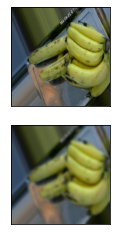

In [65]:
# Test image loader

# with image gaussian blur kernel size 13
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


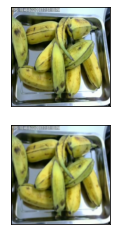

In [63]:
# Test image loader

# with image gaussian blur kernel size 3
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


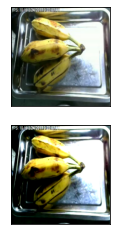

In [59]:
# Test image loader

# with image contrast 1.55
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


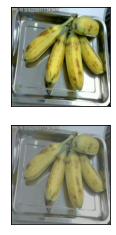

In [57]:
# Test image loader

# with image contrast 0.55
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


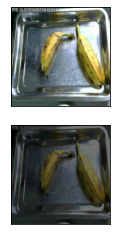

In [ ]:
# Test image loader

# with image brightness 0.45
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


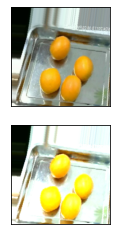

In [ ]:
# Test image loader

# with image brightness 1.66
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


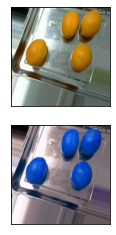

In [ ]:
# Test image loader

# with image hue adjusted to 0.5
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


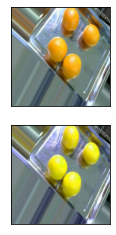

In [ ]:
# Test image loader

# with image hue adjusted to 0.05
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


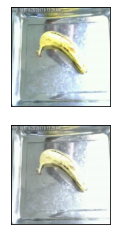

In [ ]:
# Test image loader

# with image saturation 0.55
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


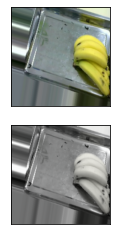

In [ ]:
# Test image loader

# with image saturation 0.05
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Saving training data features...
Original
Modified


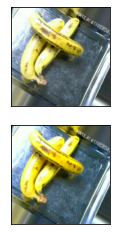

In [ ]:
# Test image loader

# with image saturation 1.7
target_classes = ['Orange', 'Gala_Apple', 'Banana']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

In [ ]:
def get_feature_loader(path, subset_classes=target_classes, batch_size=32, verify=True):
    '''
    Loads saved tensor files with features extracted using AlexNet
    '''
    # load tensor files from folder
    train_dataset = torchvision.datasets.DatasetFolder(path + '/train/features/', loader=torch.load, extensions=('.tensor'))
    val_dataset = torchvision.datasets.DatasetFolder(path + '/val/features/', loader=torch.load, extensions=('.tensor'))
    test_dataset = torchvision.datasets.DatasetFolder(path + '/test/features/', loader=torch.load, extensions=('.tensor'))

    # Prepare Dataloader
    num_workers = 1
    train_sampler = SubsetRandomSampler(get_relevant_indices(train_dataset, classes, subset_classes))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(get_relevant_indices(val_dataset, classes, subset_classes))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(get_relevant_indices(test_dataset, classes, subset_classes))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=test_sampler)

    # Verification Step - obtain one batch of features
    if verify is True:
      data_iter = iter(train_loader)
      features, labels = data_iter.next()
      print("Training Shape:")
      print(features.shape)
      print(labels.shape)

      data_iter = iter(val_loader)
      features, labels = data_iter.next()
      print("Validation Shape:")
      print(features.shape)
      print(labels.shape)

      data_iter = iter(test_loader)
      features, labels = data_iter.next()
      print("Test Shape:")
      print(features.shape)
      print(labels.shape)
      print('\n')

    return train_loader, val_loader, test_loader

In [ ]:
# Load saved AlexNet features, batch size 64; TEST
#train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=64)

FileNotFoundError: ignored

# CNN Model Architecture

Architecture:

Start with 1 convolution and 1 pooling layer then a FC layer

In [ ]:
torch.manual_seed(1) # set the random seed

class AlexNetCNNClassifier(nn.Module):
    def __init__(self):
        super(AlexNetCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, 3) # creates 4x4 feature map
        self.pool = nn.MaxPool2d(2, 2) # createst 2x2 feature map
        self.fc1 = nn.Linear(128*2*2, 17) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 128*2*2)
        x = self.fc1(x)
        return x

In [ ]:
def get_accuracy_AlexNet(model, data_loader, use_cuda=False):
    correct = 0
    total = 0

    # target_classes defined globally
    class_total = dict.fromkeys(target_classes, 0)
    class_correct = dict.fromkeys(target_classes, 0)
    
    for imgs, labels in data_loader:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    if total is 0:
      return -8 # basically None value to show something is wrong

    return correct / total

def train_AlexNet(model, train_loader, val_loader, num_epochs=1, batch_size=32, learn_rate=0.001, use_cuda=False):
    # Note train_loader = feature_loader

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    iters, train_acc, val_acc = [], [], []

    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):

        for imgs, labels in iter(train_loader):
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)       # forward pass, imgs already the features extracted from AlexNet
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        # save the current training information
        iters.append(n)
        train_acc.append(get_accuracy_AlexNet(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy_AlexNet(model, val_loader))  # compute validation accuracy
        print("Epoch {0} | Training Accuracy: {1} | Validation Accuracy: {2}".format(epoch + 1, train_acc[-1], val_acc[-1]))

    end_time= time.time()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
def get_each_class_accuracy(model, parent_dir, target_classes, batch_size, train_val=False,
                            test=False):


    labels, train_acc, val_acc, test_acc = [], [], [], []
    for c in target_classes:
      labels.append(c)

      # load only this class images
      train_loader, val_loader, test_loader = get_feature_loader(parent_dir, 
                                                                 subset_classes=[c],
                                                                 batch_size=batch_size,
                                                                 verify=False)
      if train_val is True:
        train_acc.append(get_accuracy_AlexNet(model, train_loader))
        val_acc.append(get_accuracy_AlexNet(model, val_loader))

      if test is True:
        test_acc.append(get_accuracy_AlexNet(model, test_loader))

    # output
    print("{:<25} | Train | Validation | Test |".format("Class"))
    print("-------------------------------------------------------")
    for i in range(len(labels)):
      if train_val is True:
        print("{:<25} | {:^5.2f} | {:^10.2f} | {:^4} |".format(
          labels[i], train_acc[i], val_acc[i], "-"))

      if test is True:
        print("{:<25} | {:^5} | {:^10} | {.^2f} |".format(
          labels[i], "-", "-", test_acc[i]))
    return

In [ ]:
get_each_class_accuracy(model, parent_dir, target_classes, batch_size=64, train_val=True,
                            test=False)

                          | Train | Validation | Test |
-------------------------------------------------------
Banana                    | 1.00  |    1.00    |  -   |
Carambola                 | 1.00  |    1.00    |  -   |
Fuji_Apple                | 1.00  |    0.99    |  -   |
Gala_Apple                | 1.00  |    1.00    |  -   |
Golden_Delicious_Apple    | 1.00  |    0.99    |  -   |
Granny_Smith_Apple        | 1.00  |    1.00    |  -   |
Mango                     | 1.00  |    1.00    |  -   |
Orange                    | 1.00  |    0.99    |  -   |
Peach                     | 1.00  |    1.00    |  -   |
Pear                      | 1.00  |    1.00    |  -   |
Persimmon                 | 1.00  |    1.00    |  -   |
Pitaya                    | 1.00  |    0.99    |  -   |
Plum                      | 1.00  |    0.99    |  -   |
Pomegranate               | 1.00  |    1.00    |  -   |
Red_Delicious_Apple       | 1.00  |    0.99    |  -   |
Tomatoes                  | -8.00 |   -8.00    |

Tune Hyperparameter with All Datasets

Saving training data features...
Saving validation data features...
Saving test data features...
Total time:   1635.32 s


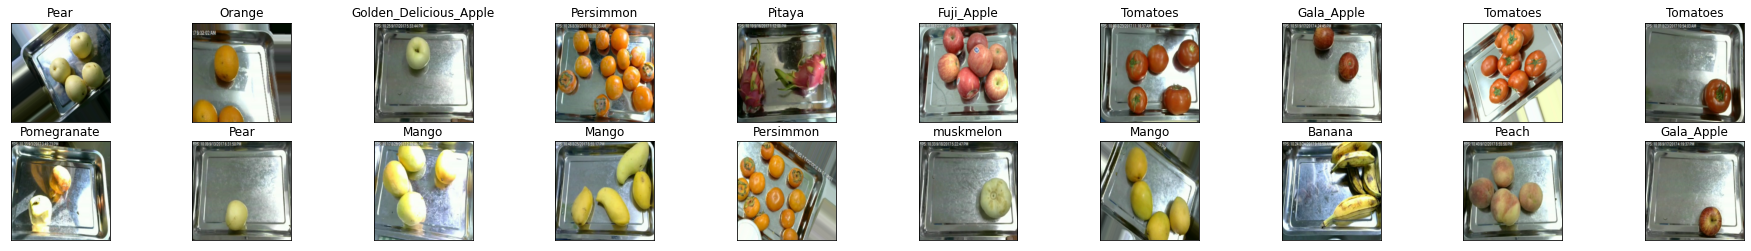

In [ ]:
# exclude kiwi and guava which have a weird file structure
target_classes = ['Banana', 'Carambola', 'Fuji_Apple', 'Gala_Apple', 'Golden_Delicious_Apple', 
                  'Granny_Smith_Apple','Mango', 'Orange', 
                  'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate',
                  'Red_Delicious_Apple', 'Tomatoes', 'muskmelon']
get_alexnet_features(parent_dir, classes, target_classes, verify=True)

Training Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Validation Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])
Test Shape:
torch.Size([64, 256, 6, 6])
torch.Size([64])


Training Started...
Epoch 1 | Training Accuracy: 0.9907264995928707 | Validation Accuracy: 0.9836133296612504
Epoch 2 | Training Accuracy: 0.9971500949968335 | Validation Accuracy: 0.9907738914899477
Epoch 3 | Training Accuracy: 0.999095268252963 | Validation Accuracy: 0.9920132194987606
Epoch 4 | Training Accuracy: 0.9993214511897223 | Validation Accuracy: 0.9943541724042964
Epoch 5 | Training Accuracy: 0.9929430923731114 | Validation Accuracy: 0.9829248141007987
Epoch 6 | Training Accuracy: 0.9917217045146114 | Validation Accuracy: 0.97934453318645
Epoch 7 | Training Accuracy: 0.9992762146023704 | Validation Accuracy: 0.9924263288350317
Epoch 8 | Training Accuracy: 0.9999547634126481 | Validation Accuracy: 0.9960066097493804
Epoch 9 | Training Accuracy: 1.0 | Validation Accuracy: 0.9968328284219223
Epoch

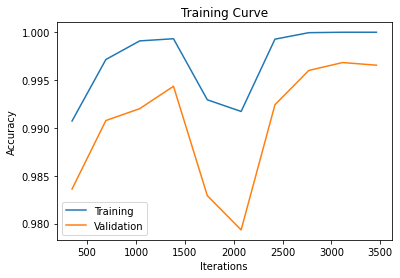

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9965574221977417
Total time:   275.16 s  Time per Epoch:  27.52 s 


In [ ]:
# With 17 classes and V3
model = AlexNetCNNClassifier()
train_loader, val_loader, test_loader = get_feature_loader(parent_dir, batch_size=64) # reload AlexNet features with new batch_size
train_AlexNet(model, train_loader, val_loader, batch_size=64, num_epochs=10)